In [48]:
import os
import pandas as pd
import requests
import yfinance as yf
import datetime
import re
from dateutil import parser
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import json
import matplotlib.pyplot as plt
from config import SERPAPI_KEY
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

In [49]:
# get the news
def fetch_google_news(query="Deepseek AI", num_results=100, start_date="01/01/2025", end_date="02/03/2025"):
    news_df=pd.DataFrame()
    params = {
        "q": query,
        "api_key": SERPAPI_KEY,
        "tbm": "nws",
        "num": num_results,
        "tbs": f"cdr:1,cd_min:{start_date},cd_max:{end_date}",
    }
    for i in range(50):
        try:
            params['offset']=i*100
            response = requests.get("https://serpapi.com/search", params=params)
            response.raise_for_status()
            results = response.json()
            articles = []
            if "news_results" in results:
                for news in results["news_results"]:
                    articles.append({
                        "title": news.get("title"),
                        "link": news.get("link"),
                        "source": news.get("source"),
                        "published_date": news.get("date"),
                        "snippet": news.get("snippet"),
                    })

            # Convert to DataFrame
            news_df = pd.concat([news_df,pd.DataFrame(articles)])

            # Save JSON & CSV

        except requests.exceptions.RequestException as e:
            print(f" Error: Failed to fetch news - {e}")
            return None
    news_df.to_csv("deepseek_news.csv", index=False)
    with open("news_data.json", "w", encoding="utf-8") as json_file:
        json.dump(results, json_file, indent=4)

        print(f" News data saved ({len(news_df)} articles).")
    return news_df if not news_df.empty else None

In [50]:
# Convert relative dates to actual dates
def convert_relative_date(date_str):
    if isinstance(date_str, str):
        match = re.search(r"(\d+)\s+(day|week|month|hour|minute|second)", date_str)
        if match:
            value, unit = int(match.group(1)), match.group(2)
            delta = {
                "day": datetime.timedelta(days=value),
                "week": datetime.timedelta(weeks=value),
                "month": datetime.timedelta(days=value * 30),
                "hour": datetime.timedelta(hours=value),
                "minute": datetime.timedelta(minutes=value),
                "second": datetime.timedelta(seconds=value),
            }
            return datetime.datetime.today() - delta.get(unit, datetime.timedelta(days=0))
        try:
            return parser.parse(date_str)
        except ValueError:
            return None
    return date_str

In [51]:
# Sentiment Analysis Function
def analyze_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(str(text))
    return "Positive" if vs['compound'] >= 0.05 else "Negative" if vs['compound'] <= -0.05 else "Neutral"

In [52]:
# Get the stock data
def fetch_stock_data(tickers=["GOOGL", "MSFT", "NVDA", "META"], start_date="2023-01-01"):
    end_date = datetime.datetime.today().strftime('%Y-%m-%d')
    stock_data = {}

    for ticker in tickers:
        try:
            stock_df = yf.download(ticker, start=start_date, end=end_date)
            if not stock_df.empty:
                stock_df.reset_index(inplace=True)
                stock_df.to_csv(f"stock_data/{ticker}_stock_data.csv", index=False)
                stock_data[ticker] = stock_df
                print(f" Stock data saved: {ticker} ({len(stock_df)} records).")
        except Exception as e:
            print(f" Error fetching stock data for {ticker}: {e}")

    return stock_data

In [53]:
# Execution:
news_df = fetch_google_news()

if news_df is not None:
    news_df["published_date"] = news_df["published_date"].apply(convert_relative_date)
    news_df["published_date"] = pd.to_datetime(news_df["published_date"], errors="coerce")
    news_df.dropna(subset=["published_date"], inplace=True)

    # Do the  sentiment analysis
    news_df["sentiment"] = news_df["title"].apply(analyze_sentiment)
    news_df.to_csv("news_data/deepseek_news_with_sentiment.csv", index=False)
    print("Sentiment analysis completed and saved.")

 News data saved (5000 articles).
Sentiment analysis completed and saved.


In [54]:
# Get the stock data
stock_data = fetch_stock_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 Stock data saved: GOOGL (525 records).
 Stock data saved: MSFT (525 records).
 Stock data saved: NVDA (525 records).
 Stock data saved: META (525 records).


In [57]:
# make sentiment Pie Charts by week
def generate_sentiment_charts(file_path="news_data/deepseek_news_with_sentiment.csv"):
    df = pd.read_csv(file_path)
     # Convert date columns
    df["published_date"] = pd.to_datetime(df["published_date"], errors="coerce")
    df.dropna(subset=["published_date"], inplace=True)

    # get year and week number
    df["year_week"] = df["published_date"].dt.strftime("%Y-W%U")

    # Group by week and count sentiment count
    weekly_sentiment = df.groupby(["year_week", "sentiment"]).size().unstack(fill_value=0)
    weekly_sentiment.to_csv('Weekly Sentiment Numbers.csv')
    # Create output directory
    output_dir = "weekly_sentiment_charts"
    os.makedirs(output_dir, exist_ok=True)

    # make pie charts
    for week, data in weekly_sentiment.iterrows():
        plt.figure(figsize=(6, 6))
        data.plot.pie(autopct='%1.1f%%', startangle=140, cmap="coolwarm", legend=False)
        plt.title(f"Sentiment Distribution for Week {week}")
        plt.ylabel("")
        plt.savefig(f"{output_dir}/sentiment_week_{week}.png")
        plt.close()
        print(f" Pie chart created for {week}")

    print("\nAll weekly sentiment charts have been generated and saved!")
    return weekly_sentiment

In [58]:
# Run Sentiment Chart
weekly_sentiment=generate_sentiment_charts()

 Pie chart created for 2025-W03
 Pie chart created for 2025-W04
 Pie chart created for 2025-W05

All weekly sentiment charts have been generated and saved!


In [59]:
print(weekly_sentiment)
neutrals=[weekly_sentiment.loc['2025-W03','Neutral'],weekly_sentiment.loc['2025-W04','Neutral']]
totals=[weekly_sentiment.loc['2025-W03'].sum(),weekly_sentiment.loc['2025-W04'].sum()]
print('The p-value that the proportion of articles that were neutral about the issue of AI is higher in week 4 than in week three is '+str( proportions_ztest(neutrals,totals,alternative='smaller')[1]))
neutrals=[weekly_sentiment.loc['2025-W04','Neutral'],weekly_sentiment.loc['2025-W05','Neutral']]
totals=[weekly_sentiment.loc['2025-W04'].sum(),weekly_sentiment.loc['2025-W05'].sum()]
print('The p-value that the proportion of articles that were neutral about the issue of AI is higher in week 5 than in week 4 is '+str( proportions_ztest(neutrals,totals,alternative='smaller')[1]))

sentiment  Negative  Neutral  Positive
year_week                             
2025-W03         50       50        50
2025-W04       1300     2000      1200
2025-W05        100      150       100
The p-value that the proportion of articles that were neutral about the issue of AI is higher in week 4 than in week three is 0.0035054605993807934
The p-value that the proportion of articles that were neutral about the issue of AI is higher in week 5 than in week 4 is 0.7176238391464981


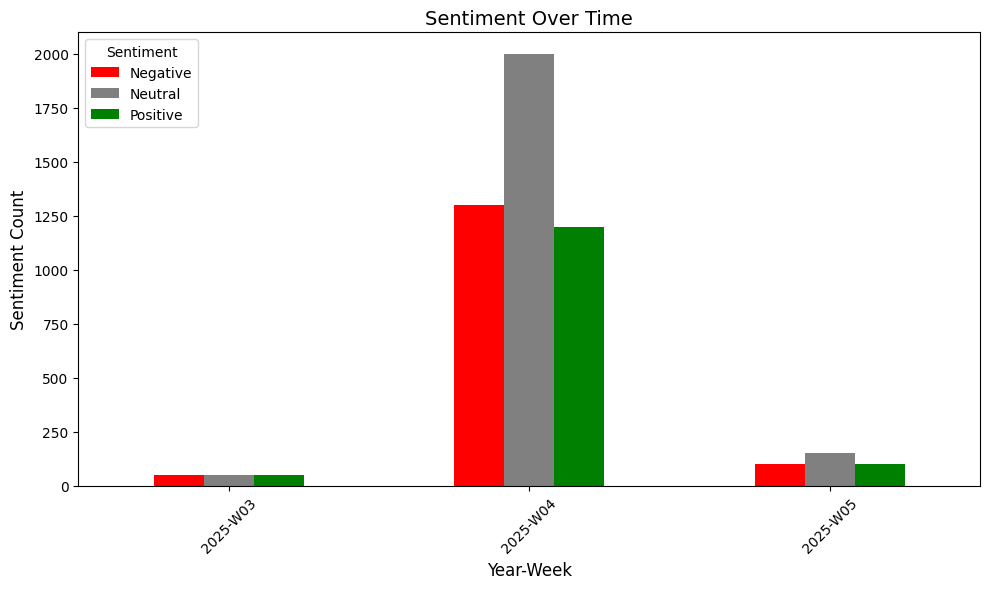

In [69]:

color_map = {
    'Negative': 'red',
    'Neutral': 'gray',
    'Positive': 'green'
}
ax = weekly_sentiment.plot(kind='bar', figsize=(10, 6), color=[color_map[col] for col in weekly_sentiment.columns])
plt.title('Sentiment Over Time', fontsize=14)
plt.xlabel('Year-Week', fontsize=12)
plt.ylabel('Sentiment Count', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Sentiment', loc='upper left')
plt.tight_layout()
plt.savefig("weekly_sentiment_charts/sentiment_bar_chart.png", dpi=300, bbox_inches="tight")
plt.show()

In [27]:
# Research question # 1. AI stock vs. Nasdaq Composite Index
tickers = {
    "GOOGL": "Google",
    "MSFT": "Microsoft",
    "NVDA": "NVIDIA",
    "META": "Meta",
     "IBM": "IBM",
      "AAPL":"Apple",
       "T": "AT&T",
    "^IXIC": "Nasdaq Composite"  # Nasdaq Composite Index
}

In [28]:
# Define the date range (past two years)
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=2*365)

In [29]:
# Get stock data
stock_data = {}
for ticker, name in tickers.items():
    try:
        data = yf.download(ticker, start=start_date, end=end_date)
        if not data.empty:
            # Use 'Adj Close' if available, otherwise use 'Close'
            stock_data[ticker] = data["Adj Close"] if "Adj Close" in data else data["Close"]
            print(f" Fetched data for {name} ({ticker})")
        else:
            print(f" No data found for {name} ({ticker})")
    except Exception as e:
        print(f" Error fetching data for {name} ({ticker}): {e}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


 Fetched data for Google (GOOGL)
 Fetched data for Microsoft (MSFT)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


 Fetched data for NVIDIA (NVDA)
 Fetched data for Meta (META)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


 Fetched data for IBM (IBM)
 Fetched data for Apple (AAPL)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 Fetched data for AT&T (T)
 Fetched data for Nasdaq Composite (^IXIC)


In [30]:
# Normalize stock
normalized_data = {}
for ticker, prices in stock_data.items():
    normalized_data[ticker] = (prices / prices.iloc[0]) * 100  # Normalize to starting price

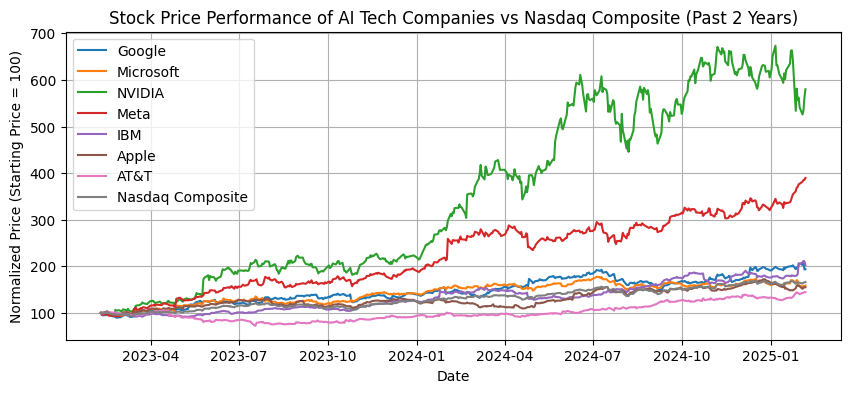

In [32]:
# Plot the data
plt.figure(figsize=(10, 4))
for ticker, prices in normalized_data.items():
    plt.plot(prices, label=tickers[ticker])

plt.title("Stock Price Performance of AI Tech Companies vs Nasdaq Composite (Past 2 Years)")
plt.xlabel("Date")
plt.ylabel("Normalized Price (Starting Price = 100)")
plt.legend(loc="upper left")
plt.grid(True)
# Save the figure as a png
plt.savefig("stock_charts/2_year_stock_performance.png", dpi=300, bbox_inches="tight")

plt.show()

In [38]:
stock_summary = []
for ticker, prices in stock_data.items():
    initial_price = round(prices.iloc[0,0], 2)
    final_price = round(prices.iloc[-1,0], 2)
    percent_change = round(((final_price - initial_price) / initial_price) * 100, 2)

    stock_summary.append({
        "Ticker": ticker,
        "Initial Price": initial_price,
        "Final Price": final_price,
        "Percentage Change (%)": percent_change
    })

stock_summary_df = pd.DataFrame(stock_summary)
stock_summary_df

,Ticker,Initial Price,Final Price,Percentage Change (%)
0,GOOGL,99.01,191.60,93.52
1,MSFT,262.42,415.82,58.46
2,NVDA,22.19,128.68,479.90
3,META,182.73,711.99,289.64
4,IBM,125.03,253.44,102.70
5,AAPL,150.34,233.22,55.13
6,T,16.94,24.45,44.33
7,^IXIC,11910.52,19791.99,66.17


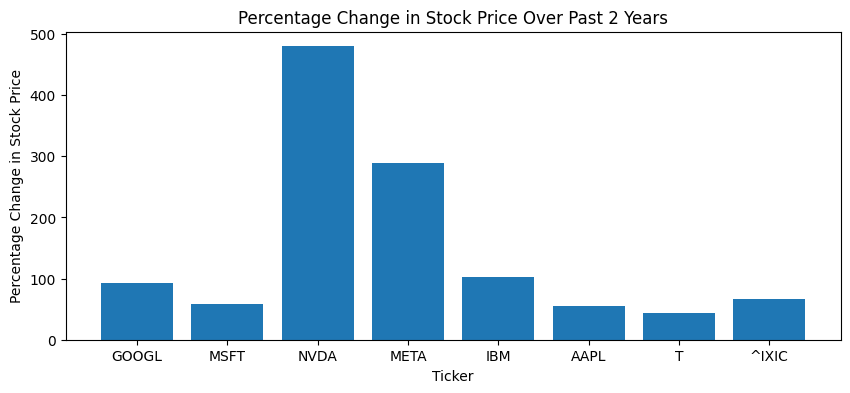

In [65]:
plt.figure(figsize=(10, 4))

plt.bar(stock_summary_df["Ticker"], stock_summary_df["Percentage Change (%)"])
plt.title("Percentage Change in Stock Price Over Past 2 Years")
plt.xlabel("Ticker")
plt.ylabel("Percentage Change in Stock Price")
plt.savefig("stock_charts/PercentageChange2Yr.png", dpi=300, bbox_inches="tight")
plt.show()

In [50]:
ticker_no_nasdaq = {
    "GOOGL": "Google",
    "MSFT": "Microsoft",
    "NVDA": "NVIDIA",
    "META": "Meta",
     "IBM": "IBM",
      "AAPL":"Apple",
       "T": "AT&T"
}

In [51]:
# Get volume data
volume_data = {}
for ticker, name in ticker_no_nasdaq.items():
    try:
        voldata = yf.download(ticker, start=start_date, end=end_date)
        if not voldata.empty:
            # Grab volume data
            volume_data[ticker] = voldata["Volume"]
            print(f" Fetched data for {name} ({ticker})")
        else:
            print(f" No data found for {name} ({ticker})")
    except Exception as e:
        print(f" Error fetching data for {name} ({ticker}): {e}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 Fetched data for Google (GOOGL)
 Fetched data for Microsoft (MSFT)
 Fetched data for NVIDIA (NVDA)
 Fetched data for Meta (META)
 Fetched data for IBM (IBM)
 Fetched data for Apple (AAPL)
 Fetched data for AT&T (T)


In [69]:
volume_df = pd.concat(volume_data, axis=1)
volume_df = volume_df / 1_000_000
volume_no_nvidia = volume_df.drop(columns=["NVDA"])

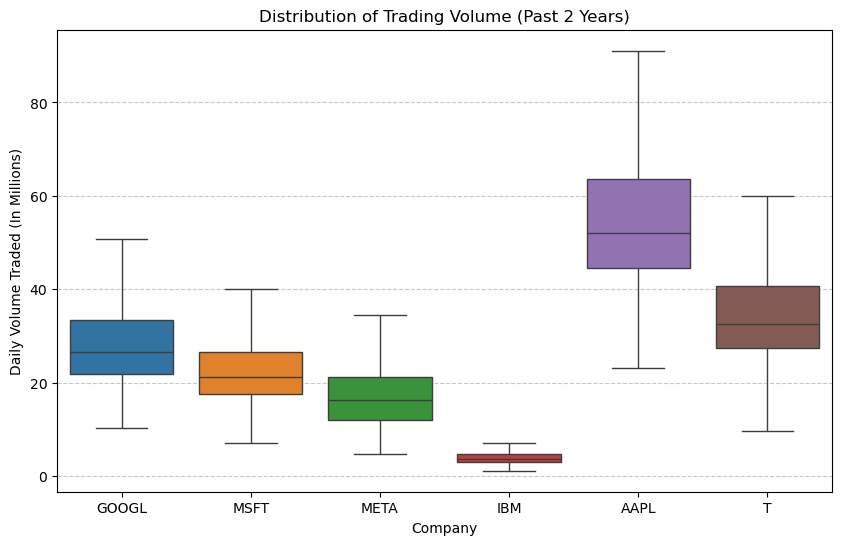

In [101]:
# Create a boxplot without Nvidia
plt.figure(figsize=(10, 6))
sns.boxplot(data=volume_no_nvidia, showfliers=False)

# Formatting
plt.title("Distribution of Trading Volume (Past 2 Years)")
plt.xlabel("Company")
plt.ylabel("Daily Volume Traded (In Millions)") 
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig("stock_charts/2yrvolume_no_nvidia.png", dpi=300, bbox_inches="tight")
# Show plot
plt.show()

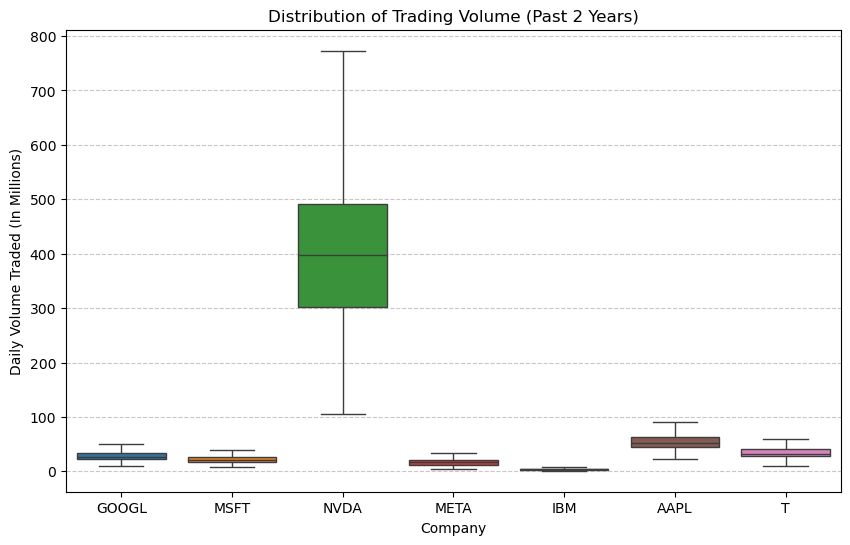

In [102]:
# Create a boxplot with Nvidia
plt.figure(figsize=(10, 6))
sns.boxplot(data=volume_df, showfliers=False)

# Formatting
plt.title("Distribution of Trading Volume (Past 2 Years)")
plt.xlabel("Company")
plt.ylabel("Daily Volume Traded (In Millions)") 
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig("stock_charts/2yrvolume.png", dpi=300, bbox_inches="tight")
# Show plot
plt.show()

In [32]:
start_date2 = end_date - datetime.timedelta(days=30)

In [33]:
# Get recent stock data
stock_data_recent = {}
for ticker, name in tickers.items():
    try:
        data2 = yf.download(ticker, start=start_date2, end=end_date)
        if not data2.empty:
            # Use 'Adj Close' if available, otherwise use 'Close'
            stock_data_recent[ticker] = data2["Adj Close"] if "Adj Close" in data2 else data2["Close"]
            print(f' Fetched data for {name} ({ticker})')
        else:
            print(f' No data found for {name} ({ticker})')
    except Exception as e:
        print(f' Error fetching data for {name} ({ticker}): {e}')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


 Fetched data for Google (GOOGL)
 Fetched data for Microsoft (MSFT)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


 Fetched data for NVIDIA (NVDA)
 Fetched data for Meta (META)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


 Fetched data for IBM (IBM)
 Fetched data for Apple (AAPL)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 Fetched data for AT&T (T)
 Fetched data for Nasdaq Composite (^IXIC)


In [35]:
# Normalize stock
normalized_data2 = {}
for ticker, prices in stock_data_recent.items():
    normalized_data2[ticker] = (prices / prices.iloc[0]) * 100

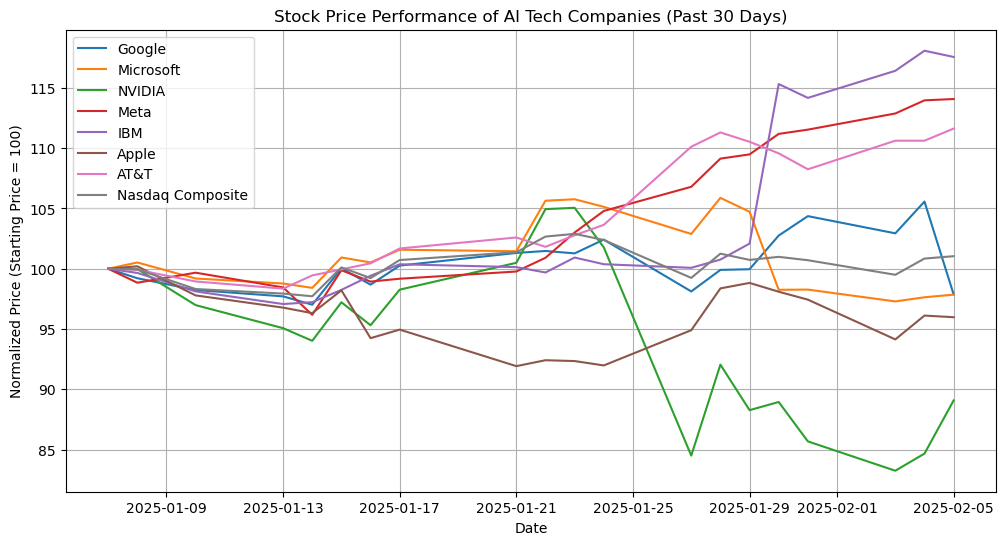

In [103]:
# Plot the data
plt.figure(figsize=(12, 6))
for ticker, prices in normalized_data2.items():
    plt.plot(prices, label=tickers[ticker])

plt.title("Stock Price Performance of AI Tech Companies (Past 30 Days)")
plt.xlabel("Date")
plt.ylabel("Normalized Price (Starting Price = 100)")
plt.legend(loc="upper left")
plt.grid(True)
# Save the figure as a png
plt.savefig("stock_charts/30_day_stock_performance.png", dpi=300, bbox_inches="tight")

plt.show()

In [90]:
# Input data from Nvidia previous earnings report
nvidia_revenue = {
    "Market": ["Data Center", "Gaming", "Other"],
    "Revenue in millions": [30771, 3279, 1032]
}
nvidia_df = pd.DataFrame(nvidia_revenue)
nvidia_df

,Market,Revenue in millions
0,Data Center,30771
1,Gaming,3279
2,Other,1032


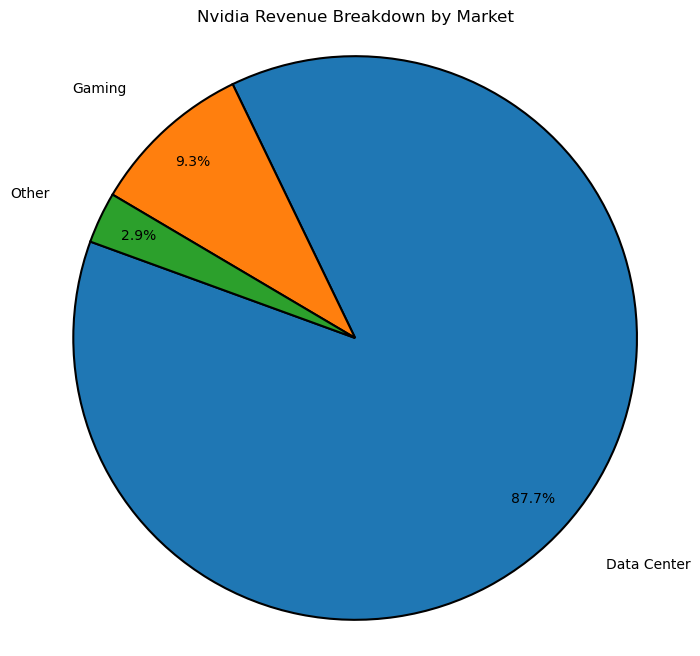

In [105]:

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(nvidia_df['Revenue in millions'], labels=nvidia_df['Market'], autopct='%1.1f%%', startangle=160, 
        labeldistance=1.2,  # Adjust label distance (move labels outwards)
        pctdistance=0.85,   # Adjust percentage distance (move percentages inwards)
        wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})

# Formatting the pie chart
plt.title('Nvidia Revenue Breakdown by Market')
plt.axis('equal')
plt.savefig("stock_charts/nvidia_revenue.png", dpi=300, bbox_inches="tight")
# Show the chart
plt.show()